In [1]:
import numpy as np 
import pandas as pd
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import max_norm
from keras.optimizers import SGD
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from keras.utils import to_categorical
from keras import backend as K
from random import randint
%matplotlib inline

np.random.seed(7)
K.set_image_data_format('channels_last')

In [2]:
X_FNAME = r"C:\Users\HP\Downloads\alphanum-hasy-data-X.npy"
Y_FNAME = r"C:\Users\HP\Downloads\alphanum-hasy-data-y.npy"
SYMBOL_FNAME = r"C:\Users\HP\Downloads\symbols.csv"

In [3]:
X = np.load(X_FNAME)
y = np.load(Y_FNAME)
SYMBOLS = pd.read_csv(SYMBOL_FNAME) 
SYMBOLS = SYMBOLS[["symbol_id", "latex"]]

print("X.shape", X.shape)
print("y.shape", y.shape)
print("SYMBOLS")
SYMBOLS.head(2)

X.shape (4658, 32, 32)
y.shape (4658,)
SYMBOLS


,symbol_id,latex
0,31,A
1,32,B


In [4]:
def symbol_id_to_symbol(symbol_id = None):
    if symbol_id:
        symbol_data = SYMBOLS.loc[SYMBOLS['symbol_id'] == symbol_id]
        if not symbol_data.empty:
            return str(symbol_data["latex"].values[0])
        else:
            print("This should not have happend, wrong symbol_id = ", symbol_id)
            return None
    else: 
        print("This should not have happend, no symbol id passed")
        return None        

# test some values
print("21 = ", symbol_id_to_symbol(21))
print("32 = ", symbol_id_to_symbol(32))
print("90 = ", symbol_id_to_symbol(90))

This should not have happend, wrong symbol_id =  21
21 =  None
32 =  B
90 =  a


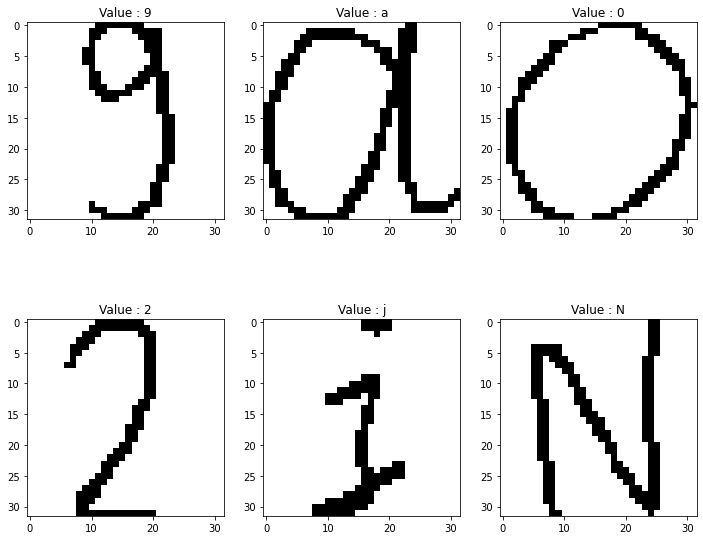

In [5]:
f, ax = plt.subplots(2, 3, figsize=(12, 10))
ax_x = 0
ax_y = 0

for i in range(6):
    randKey = randint(0, X.shape[0])
    ax[ax_x, ax_y].imshow(X[randKey], cmap='gray')
    ax[ax_x, ax_y].title.set_text("Value : " + symbol_id_to_symbol(y[randKey]))

    # for proper subplots
    if ax_x == 1:
        ax_x = 0
        ax_y = ax_y + 1
    else:
        ax_x = ax_x + 1

In [6]:
# print labels vs frequency matrix
unique, counts = np.unique(y, return_counts=True)
y_info_dict = { "labels" : unique, "counts": counts }
y_info_frame = pd.DataFrame(y_info_dict)

y_info_frame["labels"] = y_info_frame["labels"].apply(lambda x: symbol_id_to_symbol(x))
y_info_frame.head()

,labels,counts
0,A,159
1,B,61
2,C,134
3,D,58
4,E,54


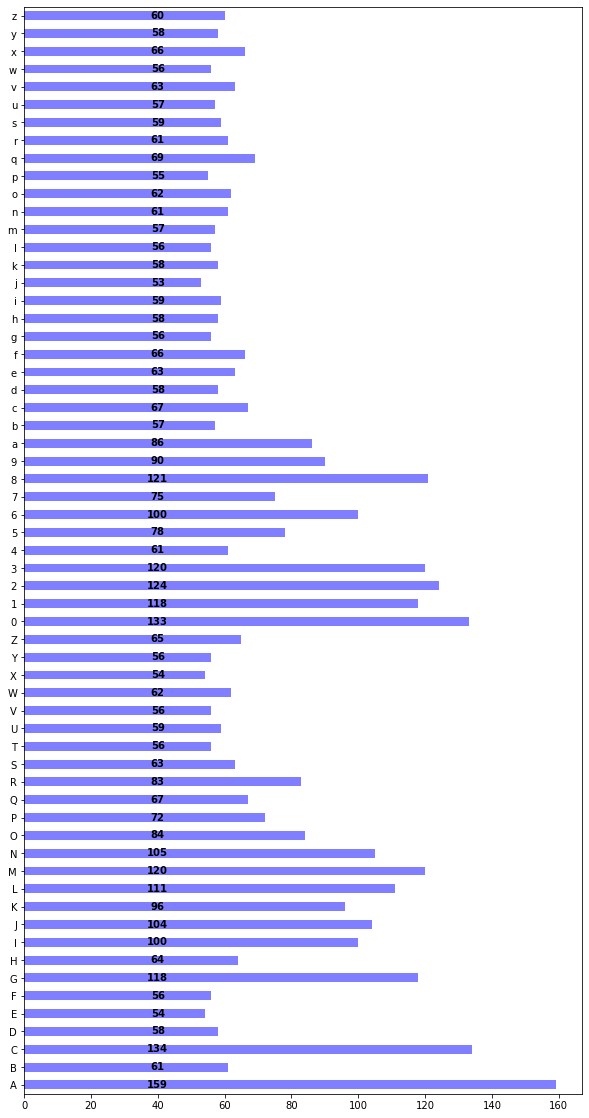

In [7]:
f, ax = plt.subplots(figsize=(10, 20))
y_info_frame["counts"].plot(kind='barh', legend=False, color="b", alpha=0.5)
wrap = ax.set_yticklabels(list(y_info_frame["labels"]))

rects = ax.patches
bar_labels_counts = list(y_info_frame["counts"])

for i in range(len(bar_labels_counts)):
    label_value = str(bar_labels_counts[i])
    ax.text(40, rects[i].get_y(), label_value, ha='center',
          va='bottom', size='medium', color="black", fontweight="bold")

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Train dataset shape")
print(X_train.shape, y_train.shape)
print("Test dataset shape")
print(X_test.shape, y_test.shape)

Train dataset shape
(3726, 32, 32) (3726,)
Test dataset shape
(932, 32, 32) (932,)


In [9]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# one hot encode outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_test.shape[1]
print("num_classes = ", num_classes)

num_classes =  116


In [10]:
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels)
X_test = X_test.reshape(X_test.shape[0], num_pixels)

def model_ANN():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels,
                    kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    
    print(model.summary())
    return model

In [11]:
# build the model
model = model_ANN()
# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=44, batch_size=100, verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 116)               118900    
                                                                 
Total params: 1168500 (4.46 MB)
Trainable params: 1168500 (4.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/44
38/38 - 4s - loss: 4.0201 - accuracy: 0.1355 - val_loss: 3.2166 - val_accuracy: 0.2006 - 4s/epoch - 95ms/step
Epoch 2/44
38/38 - 1s - loss: 2.6074 - accuracy: 0.3701 - val_loss: 2.3591 - val_accuracy: 0.4088 - 1s/epoch - 33ms/step
Epoch 3/44
38/38 - 1s - loss: 1.9424 - accuracy: 0.5102 - val_loss: 2.1055 - val_accuracy: 0.4367 - 1s/epoch - 37ms/step
Epoch 4/44
38/38 - 1s - loss: 1.5767 - accurac

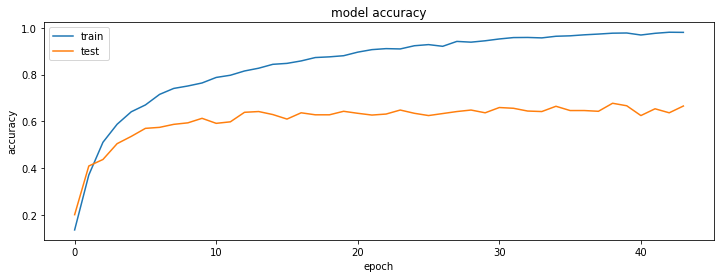

In [12]:
# summarize history for accuracy
f, ax = plt.subplots(figsize=(12, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

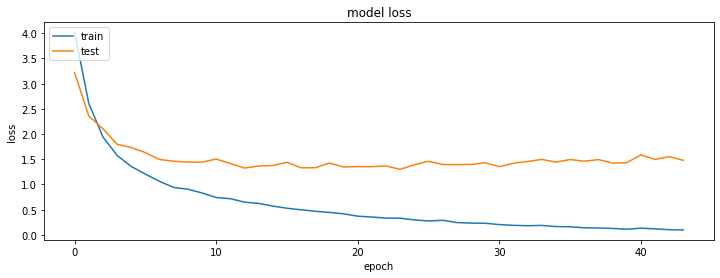

In [13]:
# summarize history for accuracy
f, ax = plt.subplots(figsize=(12, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
print("The validation accuracy is :", history.history['val_accuracy'])
print("The training accuracy is :", history.history['accuracy'])
print("The validation loss is :", history.history['val_loss'])
print("The training loss is :", history.history['loss'])

The validation accuracy is : [0.20064377784729004, 0.4087982773780823, 0.43669527769088745, 0.504291832447052, 0.5354077219963074, 0.5697425007820129, 0.5740343332290649, 0.5869098901748657, 0.5933476686477661, 0.6126609444618225, 0.5912017226219177, 0.5976395010948181, 0.6384119987487793, 0.6416308879852295, 0.6287553906440735, 0.6094420552253723, 0.6362661123275757, 0.6276823878288269, 0.6276823878288269, 0.6427038908004761, 0.6341201663017273, 0.6266094446182251, 0.6309012770652771, 0.6480686664581299, 0.6341201663017273, 0.6244634985923767, 0.6330472230911255, 0.6416308879852295, 0.6480686664581299, 0.6362661123275757, 0.6587982773780823, 0.6555793881416321, 0.6437768340110779, 0.6416308879852295, 0.6641631126403809, 0.6459227204322815, 0.6459227204322815, 0.6427038908004761, 0.6770386099815369, 0.6663089990615845, 0.6244634985923767, 0.6534335017204285, 0.6362661123275757, 0.6652360558509827]
The training accuracy is : [0.13553407788276672, 0.3701019883155823, 0.5101985931396484, 

In [15]:
GENERATED_MODEL = "alpha_num_model_v1.h5"
model.save(GENERATED_MODEL)

C:\Users\HP\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
from keras.models import load_model

model = load_model(GENERATED_MODEL)

In [21]:
test_image_key = 20 # change to test on other images
test_image = X_test[test_image_key]
test_image = test_image.reshape(1, test_image.shape[0])
test_label = y_test[test_image_key]

classes = model.predict(test_image)
output = symbol_id_to_symbol(np.argmax(classes))

1/1 [==============================] - 0s 100ms/step


Text(0.5, 0, 'Predicted Output: l')

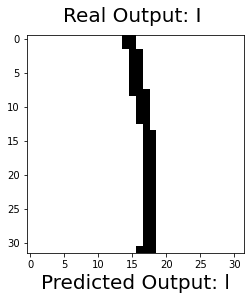

In [22]:
f, ax = plt.subplots(figsize=(4, 4))

test_image_2d = test_image.reshape(32, 32)
test_label_value = symbol_id_to_symbol(np.argmax(test_label))

ax.imshow(test_image_2d, cmap='gray')
f.suptitle("Real Output: " + test_label_value, fontsize=20)

ax.set_xlabel('Predicted Output: ' + output, fontsize=20)